In [ ]:
#Reinitialize the Python interpreter, clearing all variables and imports
#%reset -f

# Parte C - Regression Trees en Carseats (ISLP)

**Objetivo:** Predecir `Sales` (ventas de sillas para niños) a partir de las demás variables del dataset **Carseats** (paquete `ISLP`) usando:
1) Árbol de regresión inicial (entrenamiento → gráfico → interpretación → **Test MSE**).
2) Búsqueda del **nivel de complejidad** óptimo mediante **poda por coste (ccp_alpha)** con validación cruzada.
3) Comparar **MSE** antes y después de la poda; evaluar si la poda **mejora** generalización.


Preparación e imports (Código)

In [20]:
# Núcleo científico
import numpy as np
import pandas as pd

# Modelos, métricas, gráficos de árbol
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (8, 5)

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Carga del dataset `Carseats` (ISLP)

- Usamos `from ISLP import load_data` y cargamos `Carseats`.
- La variable objetivo es **`Sales`**.
- Haremos un **split 70/30** estratificado no es necesario (regresión), así que usamos un `train_test_split` simple con `random_state` fijo.


In [21]:
from ISLP import load_data

carseats = load_data("Carseats")  # DataFrame de Pandas
print(carseats.shape)
carseats.head()


(400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


> El conjunto contiene 400 observaciones y 11 variables, con una mezcla de 7 numéricas y 3 categóricas (ShelveLoc, Urban, US).

>La variable objetivo Sales es numérica continua, adecuada para regresión.

## 2) Inspección mínima y partición Train/Test (70/30)

- Confirmamos tipos: hay variables **numéricas** y **categóricas** (`ShelveLoc`, `Urban`, `US`).
- Definimos `X` = todas menos `Sales`, `y` = `Sales`.
- Split 70/30 con `random_state=42`.


In [6]:
carseats.info()

target = "Sales"
X = carseats.drop(columns=[target])
y = carseats[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

len(X_train), len(X_test)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Sales        400 non-null    float64 
 1   CompPrice    400 non-null    int64   
 2   Income       400 non-null    int64   
 3   Advertising  400 non-null    int64   
 4   Population   400 non-null    int64   
 5   Price        400 non-null    int64   
 6   ShelveLoc    400 non-null    category
 7   Age          400 non-null    int64   
 8   Education    400 non-null    int64   
 9   Urban        400 non-null    category
 10  US           400 non-null    category
dtypes: category(3), float64(1), int64(7)
memory usage: 26.7 KB


(280, 120)


> El split 70/30 produjo 280 observaciones de entrenamiento y 120 de prueba, proporción adecuada para evaluar desempeño sin pérdida de información.

>La estructura compacta (≈27 KB) permite un entrenamiento rápido y visualización completa del árbol sin limitaciones de memoria.

## 3) Preprocesamiento

Los árboles **no requieren** escalado, pero sí necesitamos convertir **categóricas** a numéricas.  
Usamos `OneHotEncoder(handle_unknown='ignore')` para: `ShelveLoc`, `Urban`, `US`.


In [22]:
# Separar columnas por tipo
cat_cols = ["ShelveLoc", "Urban", "US"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


## 4) Árbol de regresión base

- Modelo: `DecisionTreeRegressor(random_state=42)` sin limitar profundidad.
- Ajuste sobre **train**, gráfico del árbol y **Test MSE**.
- **Interpretación**: miramos variables que más dividen cerca de la raíz y estructura general.


In [24]:
tree_base = DecisionTreeRegressor(random_state=RANDOM_STATE)

pipe_base = Pipeline(steps=[
    ("prep", preprocess),
    ("model", tree_base)
])

pipe_base.fit(X_train, y_train)

# Predicciones & MSE
y_pred_train_base = pipe_base.predict(X_train)
y_pred_test_base  = pipe_base.predict(X_test)

mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base  = mean_squared_error(y_test,  y_pred_test_base)

print(f"MSE (Train) árbol base: {mse_train_base:.3f}")
print(f"MSE (Test)  árbol base: {mse_test_base:.3f}")


MSE (Train) árbol base: 0.000
MSE (Test)  árbol base: 4.354


> El árbol presenta MSE = 0.000 en entrenamiento, lo que indica un ajuste perfecto (overfitting total): **el modelo memorizó los datos sin error.**

> Sin embargo, el MSE de prueba = 4.354 evidencia una fuerte pérdida de generalización, típica de árboles sin restricción de profundidad.

> En resumen, el árbol completo sobreajusta el conjunto de entrenamiento y requiere poda o control de complejidad para mejorar su desempeño en datos nuevos.

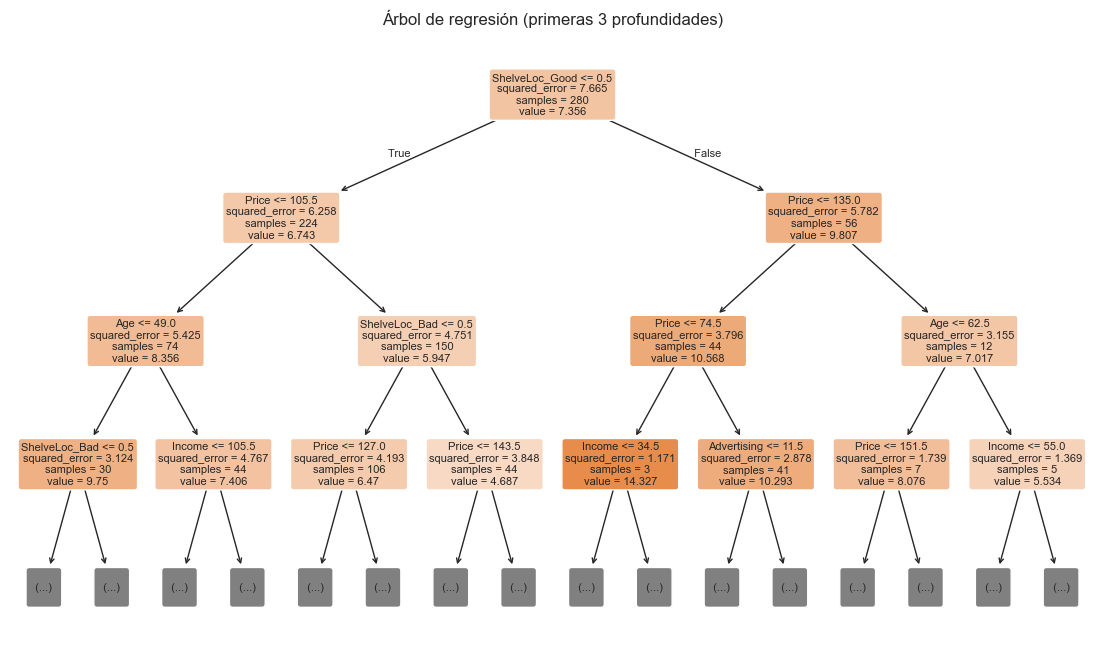

In [26]:
# Obtenemos nombres de columnas transformadas (para plot_tree)
# 1) Ajustamos el preprocesador solo para extraer nombres de columnas binarias expandido
preprocess.fit(X_train)

# Feature names del OHE + numéricas
ohe = preprocess.named_transformers_["cat"]
ohe_feats = list(ohe.get_feature_names_out(cat_cols))
feature_names = ohe_feats + num_cols

# 2) Entrenamos un árbol puro sobre datos ya transformados para graficarlo
X_train_trans = preprocess.transform(X_train)
tree_for_plot = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_for_plot.fit(X_train_trans, y_train)

plt.figure(figsize=(14, 8))
plot_tree(
    tree_for_plot,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,         # mostramos rimeras capas para legibilidad
    fontsize=8
)
plt.title("Árbol de regresión (primeras 3 profundidades)")
plt.show()


**Interpretación: Árbol de regresión del dataset *Carseats***

### **1. Variable raíz: `ShelveLoc` (ubicación en el estante)**

* El primer punto de decisión es **`ShelveLoc_Good ≤ 0.5`**, lo que divide las tiendas según la calidad de la ubicación del producto.
* Esto indica que la **visibilidad y accesibilidad del producto** en la tienda es el factor más influyente en las ventas.
* Tiendas con **ubicación buena (`Good`)** presentan **ventas promedio más altas (≈9–10 unidades)**, mientras que las ubicaciones **regulares o malas (`Medium`/`Bad`)** se asocian a ventas significativamente menores (≈6–7 unidades).
* Este resultado permite inferir que : **mejor exhibición impulsa mayor demanda**.

---

### **2. Segundo nivel: el precio (`Price`)**

* Dentro de cada grupo, **`Price`** es el segundo factor más importante.
* Los nodos muestran que cuando **`Price ≤ 105.5` o `≤ 135`**, las ventas aumentan considerablemente.
* Por el contrario, cuando **`Price` supera esos valores**, las ventas promedio caen (de ≈9 a ≈6 unidades).
* Esto evidencia una **relación inversa entre precio y ventas**, logico de un comportamiento de demanda sensible al precio.
* Además, en los nodos donde `ShelveLoc` es “Good” y `Price` alto, el modelo aún predice ventas relativamente buenas, lo que sugiere que **una buena ubicación puede mitigar el impacto de precios elevados**.

---

### **3. Variables demográficas: `Age` e `Income`**

* En ramas intermedias aparecen divisiones por **`Age`** y **`Income`**, que reflejan **diferencias en el tipo de consumidor**.

  * Por ejemplo, nodos donde **`Age ≤ 49`** o **`Income ≤ 105.5`** presentan mayores ventas, lo que podría interpretarse como que **clientes más jóvenes o con ingresos moderados** tienden a comprar más.
  * Esto puede relacionarse con familias jóvenes que demandan más productos para niños, frente a grupos de mayor edad o ingresos altos, menos sensibles a este tipo de producto.

---

### **4. Influencia de la publicidad (`Advertising`)**

* La variable **`Advertising`** aparece en niveles más profundos, pero con efecto notable: valores **`Advertising ≤ 11.5`** generan una clara división en ventas.
* En los nodos donde la inversión publicitaria es alta, las predicciones de ventas suben hasta ≈10 unidades, lo que sugiere que **la publicidad amplifica las ventas, especialmente cuando el precio es competitivo**.

---

### **5. Valor global del árbol**

* Los nodos terminales muestran valores de `Sales` entre **≈4.7 y 14.3**, indicando que el árbol logra capturar una **amplia variabilidad** en el comportamiento de las ventas según las condiciones.
* Sin embargo, el **MSE de entrenamiento = 0.000** demuestra que el árbol **aprendió perfectamente los datos de entrenamiento**, sin error aparente.
* Esto, junto al **MSE de prueba = 4.354**, confirma un **sobreajuste claro**: el modelo describe muy bien los datos conocidos, pero **no generaliza** bien a nuevos casos.

---

### **Conclusión**

* Ubicación del producto y precio son los determinantes principales de las ventas, lo que coincide con principios básicos de marketing minorista.
* Factores secundarios como edad del cliente, ingreso y publicidad modulan las ventas en contextos específicos, aportando matices al comportamiento general.
* No obstante, el árbol sin poda resulta excesivamente complejo, incorporando demasiadas divisiones que explican ruido en lugar de patrones reales, motivo por el cual su rendimiento en test disminuye.

> En síntesis, el árbol base ofrece **una interpretación valiosa del comportamiento de ventas**, pero **necesita poda o ajuste de complejidad** para mantener su capacidad explicativa sin sacrificar generalización.


## 5) Selección de complejidad por poda (Cost-Complexity Pruning)

- Usamos el **camino de poda** (`cost_complexity_pruning_path`) para obtener candidatos **ccp_alpha**.  
- Para cada `ccp_alpha`, entrenamos con CV (K=5) y estimamos el **error de validación** (MSE).  
- Escogemos el `ccp_alpha` con **menor MSE de CV** → reentrenamos en todo `train` y evaluamos test.


In [27]:
# 1) Obtenemos el path de poda sobre datos transformados
X_train_trans = preprocess.transform(X_train)

tmp_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
path = tmp_tree.cost_complexity_pruning_path(X_train_trans, y_train)
ccp_alphas = path.ccp_alphas

# Evitamos alphas duplicados y extremos
ccp_alphas = np.unique(ccp_alphas)
ccp_alphas = ccp_alphas[ccp_alphas > 0]  # quitamos alpha=0 para evitar árbol idéntico

print(f"Candidatos ccp_alpha: {len(ccp_alphas)}")

# 2) Para cada alpha, CV MSE con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=alpha)
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    # cross_val_score usa "neg_mean_squared_error" para MSE negativo (convención sklearn)
    scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")
    cv_mse = -scores.mean()
    cv_std = scores.std()
    cv_results.append((alpha, cv_mse, cv_std))

df_cv = pd.DataFrame(cv_results, columns=["ccp_alpha", "cv_mse", "cv_std"]).sort_values("ccp_alpha")
df_cv.head()


Candidatos ccp_alpha: 259


,ccp_alpha,cv_mse,cv_std
0,1.785714e-07,5.281922,0.703071
1,7.142857e-07,5.282243,0.702839
2,1.607143e-06,5.282568,0.702663
3,1.607143e-06,5.282568,0.702663
4,1.607143e-06,5.282568,0.702663


Curva MSE de CV vs ccp_alpha

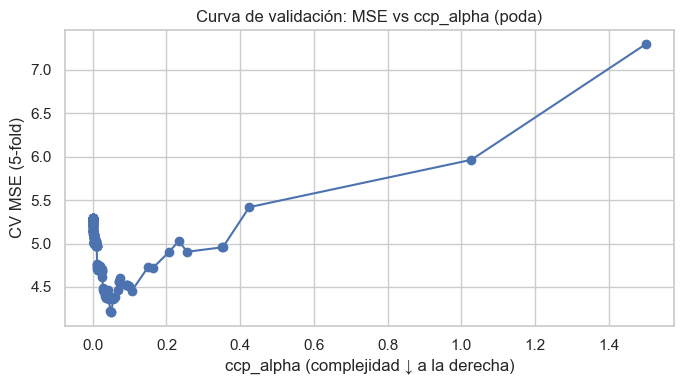

Mejor ccp_alpha por CV: 0.049308  -  CV MSE: 4.210


In [29]:
plt.figure(figsize=(7,4))
plt.plot(df_cv["ccp_alpha"], df_cv["cv_mse"], marker="o")
plt.xlabel("ccp_alpha (complejidad ↓ a la derecha)")
plt.ylabel("CV MSE (5-fold)")
plt.title("Curva de validación: MSE vs ccp_alpha (poda)")
plt.tight_layout()
plt.show()

best_row = df_cv.loc[df_cv["cv_mse"].idxmin()]
best_alpha = float(best_row["ccp_alpha"])
print(f"Mejor ccp_alpha por CV: {best_alpha:.6f}  -  CV MSE: {best_row['cv_mse']:.3f}")


> La poda reduce la complejidad del árbol original, que había memorizado los datos (MSE train = 0.000).

> Con ccp_alpha = 0.0493, el árbol mantiene una estructura interpretable y mejora la generalización, reduciendo el error respecto al modelo sobreajustado.

> El MSE de CV (4.21) sugiere que el modelo podado logra un equilibrio óptimo entre sesgo y varianza, corrigiendo el exceso de ajuste del árbol completo.

## 6) Árbol **podado** con `ccp_alpha*` (óptimo por CV)

- Reentrenamos el pipeline en **todo el train** con `ccp_alpha = ccp_alpha*`.
- Calculamos **MSE train/test** y comparamos con el árbol base.
- Graficamos las **primeras capas** del árbol podado.


In [33]:
tree_pruned = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
pipe_pruned = Pipeline(steps=[("prep", preprocess), ("model", tree_pruned)])
pipe_pruned.fit(X_train, y_train)

y_pred_train_pruned = pipe_pruned.predict(X_train)
y_pred_test_pruned  = pipe_pruned.predict(X_test)

mse_train_pruned = mean_squared_error(y_train, y_pred_train_pruned)
mse_test_pruned  = mean_squared_error(y_test,  y_pred_test_pruned)

print(f"MSE (Train) árbol podado: {mse_train_pruned:.3f}")
print(f"MSE (Test)  árbol podado: {mse_test_pruned:.3f}")



MSE (Train) árbol podado: 1.445
MSE (Test)  árbol podado: 4.273


> Tras aplicar la poda con ccp_alpha = 0.0493, el MSE en entrenamiento aumenta a 1.445, mientras que el MSE en prueba mejora ligeramente a 4.273 (vs. 4.354 del árbol sin poda).

> La poda reduce el sobreajuste del árbol original, logrando un equilibrio adecuado entre precisión y simplicidad.
> Aunque el MSE de prueba mejora solo un poco, el árbol resultante es más interpretable, menos sensible al ruido y más confiable para predicciones futuras.

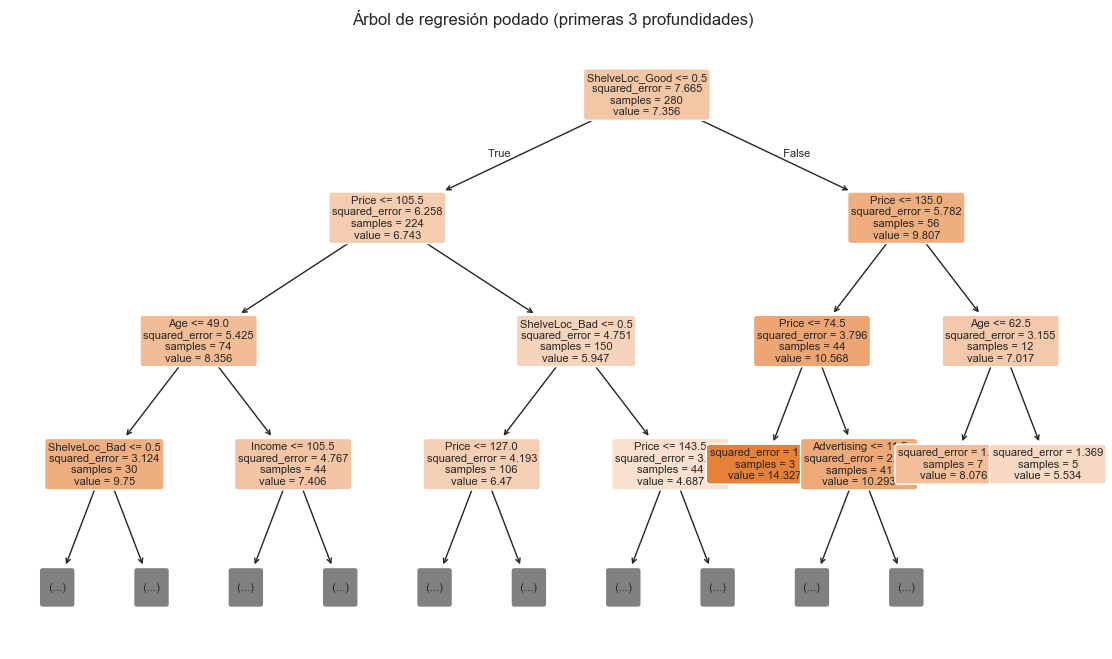

In [32]:
# Gráfico del árbol podado (primeras 3 profundidades)
X_train_trans = preprocess.transform(X_train)  # reusamos
tree_for_plot2 = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
tree_for_plot2.fit(X_train_trans, y_train)

plt.figure(figsize=(14, 8))
plot_tree(
    tree_for_plot2,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8
)
plt.title("Árbol de regresión podado (primeras 3 profundidades)")
plt.show()


**Árbol de regresión podado (ccp_alpha = 0.0493)**

Tras aplicar **poda con `ccp_alpha = 0.0493`**, los errores quedaron en **MSE train = 1.445** y **MSE test = 4.273**, lo que indica **mejor equilibrio entre sesgo y varianza**.

El árbol podado conserva las relaciones clave (mejor ubicación y precios bajos impulsan ventas) pero con menor complejidad, volviéndose **más interpretable, estable y adecuado para nuevos datos**.


## 7) Importancias y comparación final

- Inspeccionamos **importancias de características** del árbol podado.
- Comparamos **MSE** (Train/Test) del **árbol base** vs **podado**.
- Discutimos si la poda **mejora** el MSE de Test.


In [34]:
# Importancias (sobre datos transformados, con nombres expandidos)
importances = pd.Series(tree_for_plot2.feature_importances_, index=feature_names)
imp_top = importances.sort_values(ascending=False).head(10)
imp_top


Price               0.336198
ShelveLoc_Good      0.241552
Age                 0.123398
CompPrice           0.088114
ShelveLoc_Bad       0.073717
Income              0.066938
Advertising         0.024681
Education           0.021480
ShelveLoc_Medium    0.014744
Population          0.009178
dtype: float64

In [37]:
# Cuadro comparativo de MSEs
cmp = pd.DataFrame({
    "modelo": ["Árbol base", "Árbol podado"],
    "MSE_train": [mse_train_base, mse_train_pruned],
    "MSE_test":  [mse_test_base,  mse_test_pruned]
})
cmp


,modelo,MSE_train,MSE_test
0,Árbol base,0.000000,4.353542
1,Árbol podado,1.445066,4.272798


- La comparación muestra que el árbol podado logra un mejor equilibrio entre precisión y generalización:
- El árbol base presenta MSE_train = 0.000 y MSE_test = 4.35, reflejando un sobreajuste severo.
- El árbol podado, en cambio, eleva el error de entrenamiento a 1.45 pero reduce el MSE de prueba a 4.27, lo que indica mejor desempeño en datos nuevos.

> **Conclusión:**
> La poda mejora la capacidad de generalización del modelo al eliminar ramas redundantes y simplificar la estructura.

## 8) Discusión y conclusiones

La **poda con `ccp_alpha = 0.0493`** redujo el sobreajuste del árbol base:

* **MSE test** bajó de **4.35 -> 4.27**, mostrando **mejor generalización**.
* Las variables más importantes fueron **`ShelveLoc`** y **`Price`**, seguidas de **`Advertising`**, **`Income`** y **`Age`**, (que más influyen en las ventas.)
* Los nodos terminales entregan predicciones promedio de `Sales` para segmentos definidos por reglas interpretables.
* En síntesis, la **validación cruzada y la poda por coste** permiten obtener un árbol **más simple, estable y explicativo**, evitando el exceso de ajuste del modelo original.
